***
# *Importing Modules & Methods*

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import struct
from sklearn.metrics import accuracy_score

***
# *Reading Data Set & Other Helper Functions For Handling Images*

In [9]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result

In [10]:
def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [11]:
def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)


            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels

In [12]:
def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int64)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

***
# *a.*

#### *1. Building Training & Test Sets*

In [13]:
X_train, y_train = read_hoda_dataset('Train 60000.cdb')
X_test, y_test = read_hoda_dataset('Test 20000.cdb')

#### *2. Calculating Prototypes*

In [14]:
def calculate_prototypes(X_train, y_train):
    prototypes = []
    for digit_class in np.unique(y_train):
        class_samples = X_train[y_train == digit_class]
        prototype = np.mean(class_samples, axis=0)
        prototypes.append((digit_class, prototype))
    return prototypes

In [15]:
prototypes = calculate_prototypes(X_train, y_train)

#### *3. Displaying Prototypes*

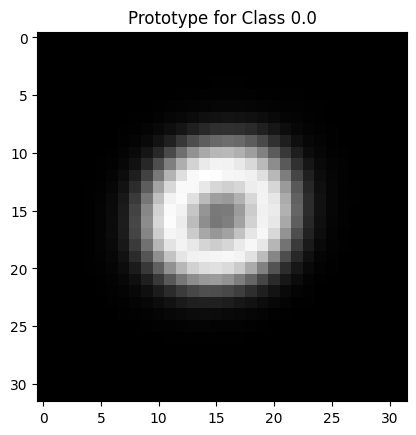

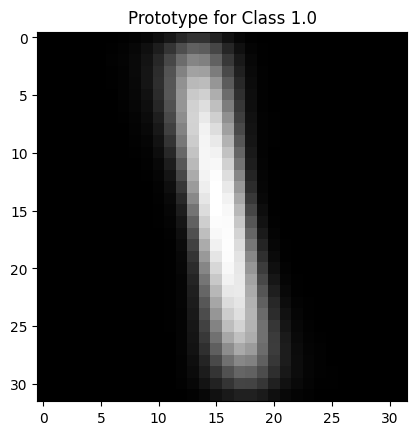

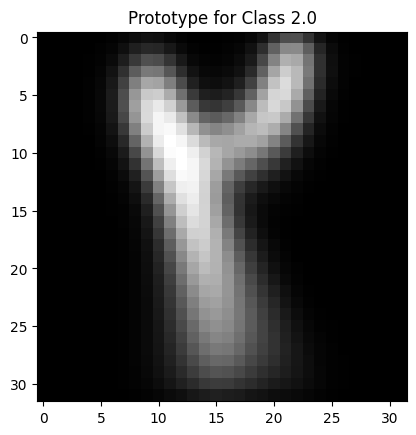

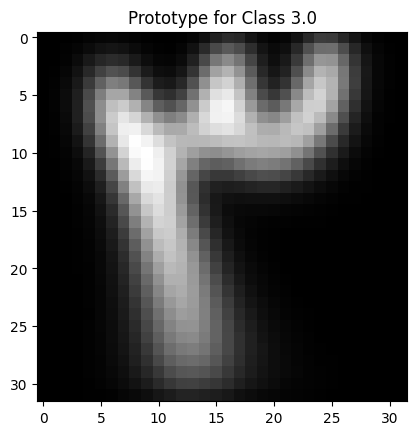

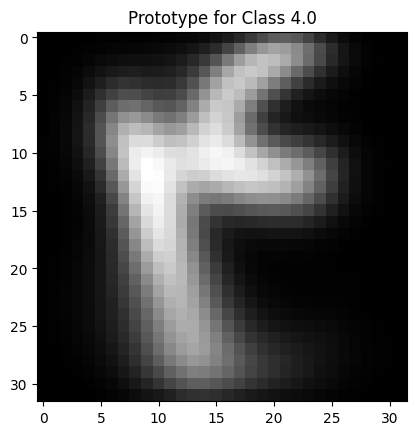

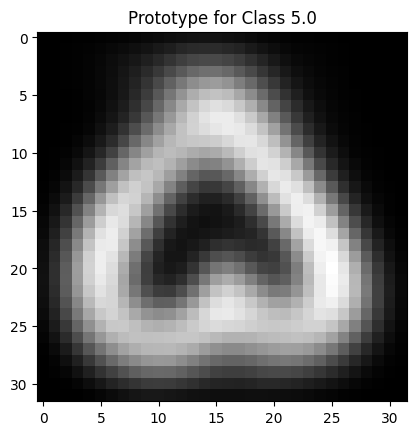

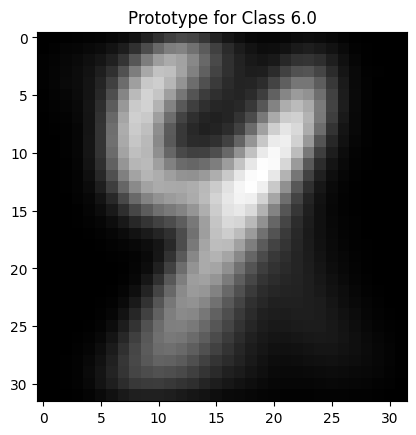

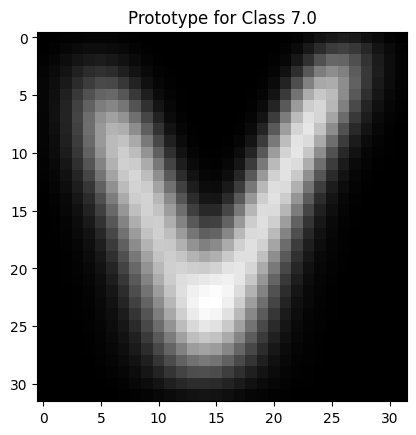

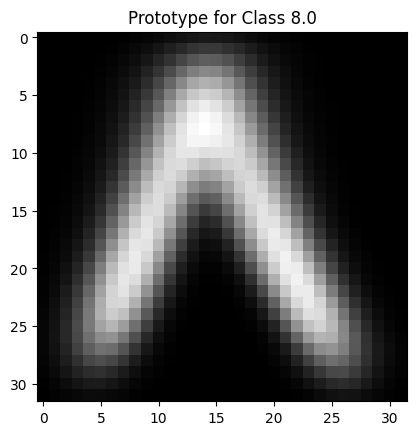

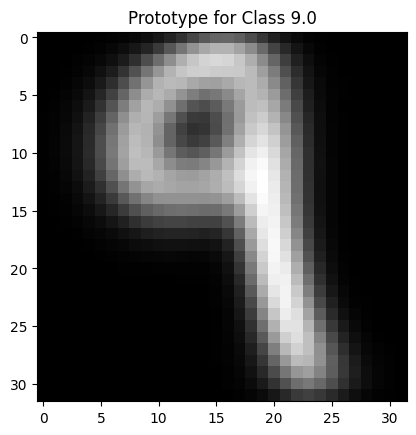

In [16]:
for digit_class, prototype in prototypes:
    image = prototype.reshape((32, 32))
    plt.imshow(image, cmap='gray')
    plt.title(f'Prototype for Class {digit_class}')
    plt.show()

# *b.*

#### *2. Implementing The Minimum Distance Classifier Function*

In [17]:
def minimum_distance_classifier(X_train, y_train, X_test):
    calculate_prototypes(X_train, y_train)

    predictions = []
    for sample in X_test:
        distances = [np.linalg.norm(sample - prototype) for (digit_class, prototype) in prototypes]
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)

    return predictions

#### *3. Calculating Predictions*

In [18]:
predictions = minimum_distance_classifier(X_train, y_train, X_test)

#### *4. Displaying  Classification Reprt & Confusion Matrix*

In [19]:
print('Classification Report:\n', classification_report(y_test, predictions))
print('Confusion Matrix:\n',confusion_matrix(y_true=y_test, y_pred=predictions))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      2000
         1.0       0.72      0.95      0.82      2000
         2.0       0.48      0.62      0.54      2000
         3.0       0.74      0.56      0.64      2000
         4.0       0.74      0.60      0.66      2000
         5.0       0.87      0.75      0.81      2000
         6.0       0.69      0.57      0.63      2000
         7.0       0.91      0.74      0.82      2000
         8.0       0.76      0.79      0.77      2000
         9.0       0.71      0.83      0.77      2000

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000

Confusion Matrix:
 [[1911    3    0    0   44   25    0   13    4    0]
 [  15 1895   71    0    1    0    4    2    0   12]
 [  11  400 1241  137   61    0   58    4    2   86]
 [  16   20  595 1128  178    9   16   

#### *5. Reporting Classification Error*

In [20]:
accuracy = accuracy_score(y_test, predictions)
classification_error = 1 - accuracy

print(f"Classification Error: {classification_error}")

Classification Error: 0.26305


#### *5. Display Erroneous Predictions*

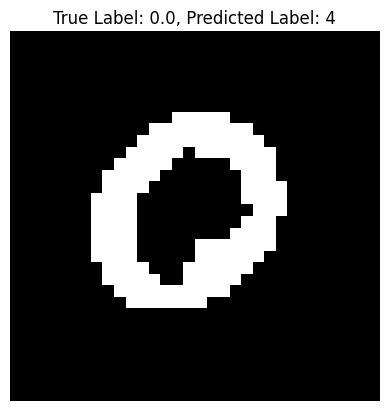

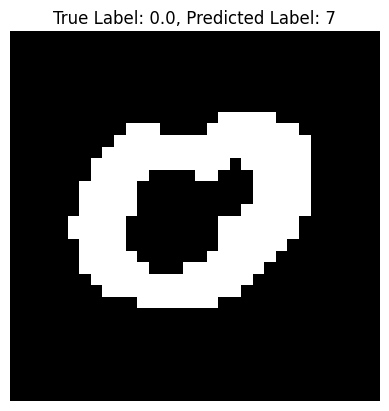

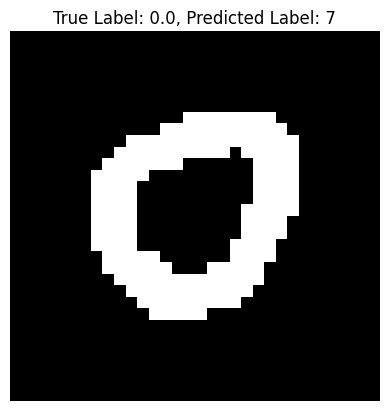

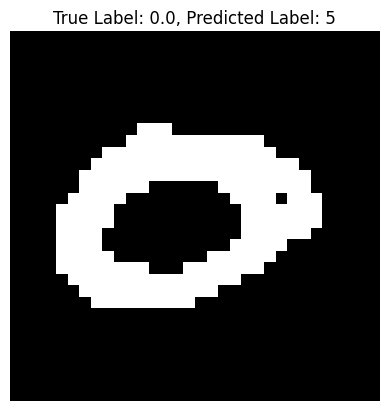

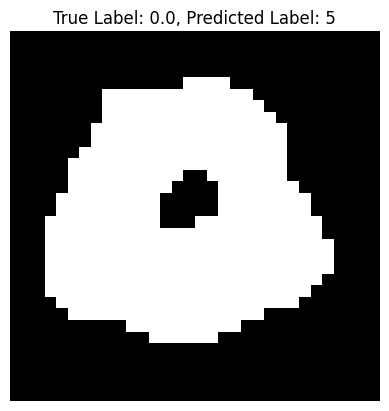

In [21]:
def display_erroneous_predictions(X_test, y_test, predictions, erroneous_indices, num_samples=5):
    for i in range(num_samples):
        index = erroneous_indices[i]
        true_label = y_test[index]
        predicted_label = predictions[index]

        sample_image = X_test[index].reshape((32, 32))
        plt.imshow(sample_image, cmap='gray')
        plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
        plt.axis('off')
        plt.show()

erroneous_indices = np.where(predictions != y_test)[0]

display_erroneous_predictions(X_test, y_test, predictions, erroneous_indices, num_samples=5)